Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch [1/50000], Loss: 22.851776
Epoch [501/50000], Loss: 0.139125
Epoch [1001/50000], Loss: 0.122393
Epoch [1501/50000], Loss: 0.118556
Epoch [2001/50000], Loss: 0.116883
Epoch [2501/50000], Loss: 0.115800
Epoch [3001/50000], Loss: 0.114857
Epoch [3501/50000], Loss: 0.114048
Epoch [4001/50000], Loss: 0.113456
Epoch [4501/50000], Loss: 0.112929
Epoch [5001/50000], Loss: 0.112431
Epoch [5501/50000], Loss: 0.112216
Epoch [6001/50000], Loss: 0.112030
Epoch [6501/50000], Loss: 0.112166
Epoch [7001/50000], Loss: 0.111928
Epoch [7501/50000], Loss: 0.111896
Epoch [8001/50000], Loss: 0.111874
Epoch [8501/50000], Loss: 0.111848
Epoch [9001/50000], Loss: 0.111829
Epoch [9501/50000], Loss: 0.111811
Epoch [10001/50000], Loss: 0.111795
Epoch [10501/50000], Loss: 0.111781
Epoch [11001/50000], Loss: 0.111768
Epoch [11501/50000], Loss: 0.111756
Epoch [12001/50000], Loss: 0.111816
Epoch [12501/50000], Loss: 0.111736
Epoch [13001/50000], Loss: 0.111728
Epoch [13501/50000], Loss: 0.111846
Epoch [14001/50

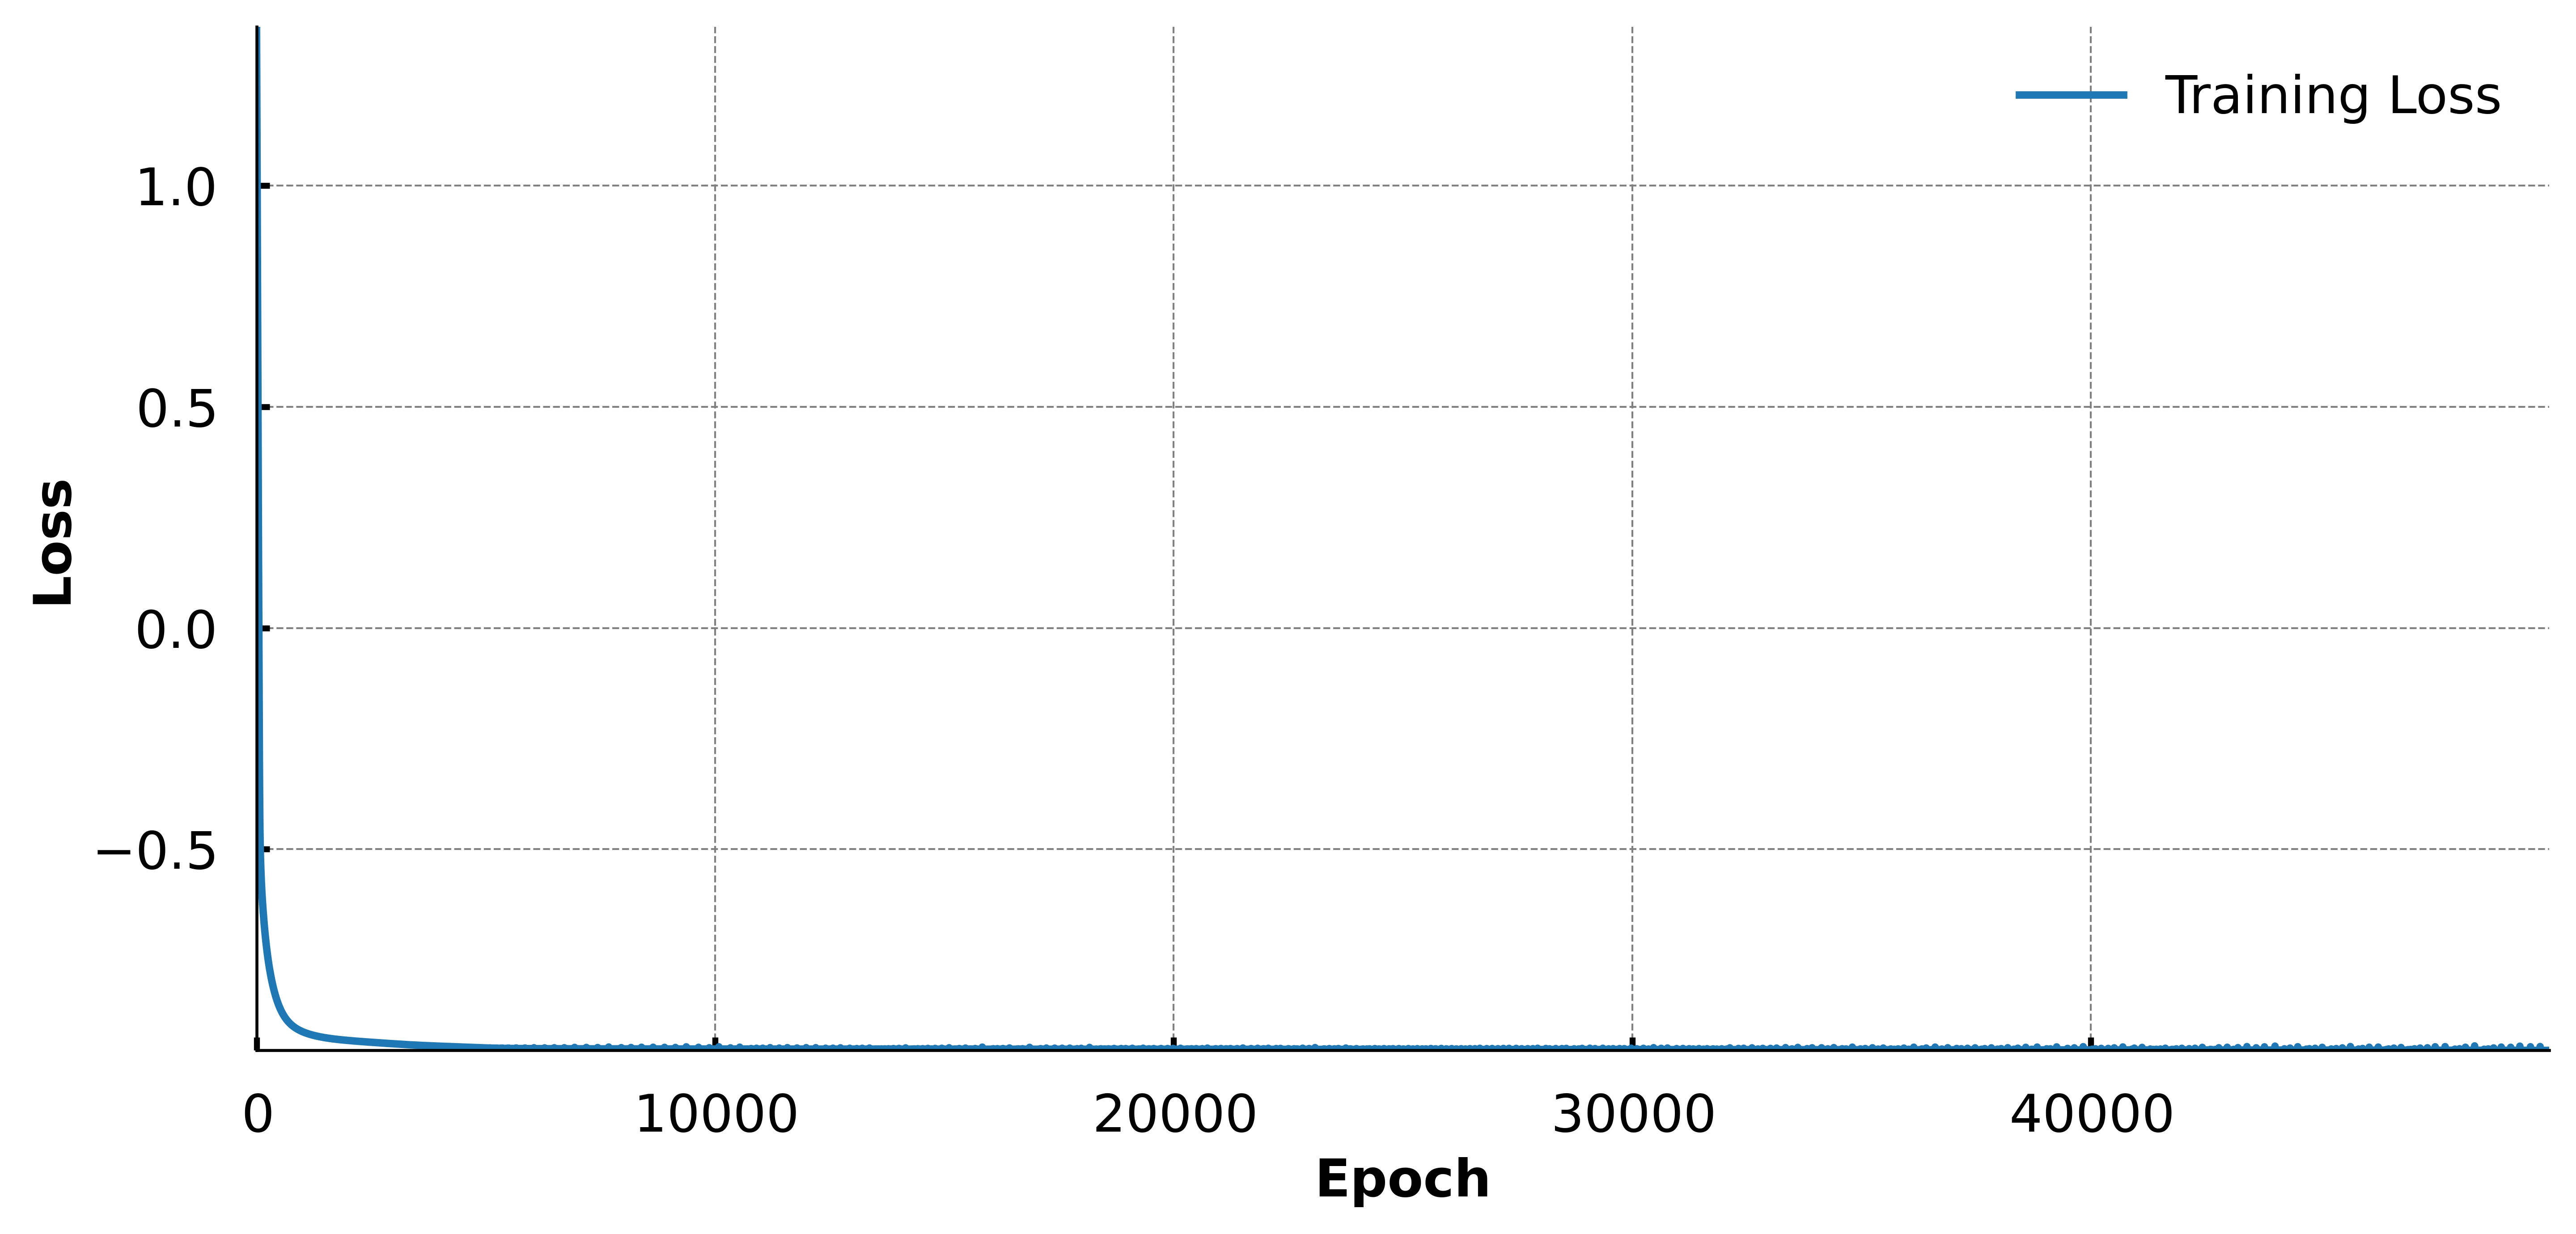

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)", "cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, e, alpha, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * (e * E + I) / N
    dEdt = beta * S * (e * E + I) / N - E / alpha
    dIdt = E / alpha - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return 0.5 * torch.tanh(self.alpha * x) + self.epsilon

class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        identity = x.clone()
        out = self.fc(x)
        out = self.activation(out)
        if out.shape == identity.shape:
            out = out + identity
        return out

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(ParamNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        params = self.net(t)
        # Ensure beta, gamma, and mu are in a valid range
        beta = torch.sigmoid(params[:, 0]) * 0.5  # range: [0, 0.5]
        gamma = torch.sigmoid(params[:, 1]) * 0.1  # range: [0, 0.1]
        mu = torch.sigmoid(params[:, 2]) * 0.1  # range: [0, 0.1]
        return beta, gamma, mu

def pinn_loss(t, data, state_nn, param_nn, N, sigma, alpha, epsilon):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    beta_pred, gamma_pred, mu_pred = param_nn(t)
    
    # SEIRD model residuals
    e_tensor = torch.tensor(epsilon, dtype=torch.float32, device=device, requires_grad=True)
    alpha_tensor = torch.tensor(alpha, dtype=torch.float32, device=device, requires_grad=True)
    
    e = torch.tanh(e_tensor)
    alpha = 2 * torch.tanh(alpha_tensor)
    
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, e, alpha, N)
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial condition loss
    loss_initial = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)
    
    # Total loss    
    total_loss = loss_data + loss_physics + loss_initial
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Define training data points
days = len(data)
t_points = np.linspace(0, days, days + 1)[:-1]
train_size = int(0.8 * days)
index = torch.randperm(train_size)

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler_state = optim.lr_scheduler.StepLR(optimizer_state, step_size=5000, gamma=0.998)
scheduler_param = optim.lr_scheduler.StepLR(optimizer_param, step_size=5000, gamma=0.998)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Use shuffled training data points
    t_train = t_data[index]
    S_train = S_data[index]
    I_train = I_data[index]
    R_train = R_data[index]
    D_train = D_data[index]
    data_tensors = (S_train, I_train, R_train, D_train)
    
    # Compute loss
    loss = pinn_loss(t_train, data_tensors, state_nn, param_nn, N, sigma, alpha, epsilon)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    scheduler_state.step()
    scheduler_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch [1/50000], Loss: 44.756699


KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Set matplotlib style and parameters
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(seed)

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["active_cases"] - df["recovered"] - df["cumulative_deceased"]

    cols_to_smooth = ["S(t)", "cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, start_date="2020-04-01", end_date="2021-12-31").drop(columns=["Unnamed: 0"], axis=1)

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["S(t)", "active_cases", "recovered", "cumulative_deceased"]])
S_raw, I_raw, R_raw, D_raw = scaled_data.T
N = data["population"].values[0]

class SEIRD_Net(nn.Module):
    def __init__(self):
        super(SEIRD_Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5),  # Output 5 values for S, E, I, R, D
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize neural network
pinn_seird = SEIRD_Net().to(device)

def network(t):
    input = t.reshape(-1, 1)
    input = torch.from_numpy(input).float().to(device)
    return pinn_seird(input) * N

# Loss functions
def residual_loss(t, beta, gamma, delta):
    dt = 1
    u = network(t)

    st2, st1 = u[1:, 0], u[:-1, 0]
    et2, et1 = u[1:, 1], u[:-1, 1]
    it2, it1 = u[1:, 2], u[:-1, 2]
    rt2, rt1 = u[1:, 3], u[:-1, 3]
    dt2, dt1 = u[1:, 4], u[:-1, 4]

    ds = (st2 - st1) / dt
    de = (et2 - et1) / dt
    di = (it2 - it1) / dt
    dr = (rt2 - rt1) / dt
    dd = (dt2 - dt1) / dt

    loss_s = (-beta * st1 * it1 - ds) ** 2
    loss_e = (beta * st1 * it1 - delta * et1 - de) ** 2
    loss_i = (delta * et1 - gamma * it1 - di) ** 2
    loss_r = (gamma * it1 - dr) ** 2
    loss_d = (it1 - dd) ** 2
    loss_n = (u[:, 0] + u[:, 1] + u[:, 2] + u[:, 3] + u[:, 4] - N) ** 2

    return loss_s.sum(), loss_e.sum(), loss_i.sum(), loss_r.sum(), loss_d.sum(), loss_n.sum()

def init_loss(t, S0, E0, I0, R0, D0):
    u = network(t)

    loss_s0 = (u[0, 0] - S0) ** 2
    loss_e0 = (u[0, 1] - E0) ** 2
    loss_i0 = (u[0, 2] - I0) ** 2
    loss_r0 = (u[0, 3] - R0) ** 2
    loss_d0 = (u[0, 4] - D0) ** 2

    return loss_s0 + loss_e0 + loss_i0 + loss_r0 + loss_d0

def data_loss(t, index):
    u = network(t)
    loss_st = (u[index, 0] - torch.from_numpy(S_raw[index]).to(device)) ** 2
    loss_it = (u[index, 2] - torch.from_numpy(I_raw[index]).to(device)) ** 2
    loss_rt = (u[index, 3] - torch.from_numpy(R_raw[index]).to(device)) ** 2
    loss_dt = (u[index, 4] - torch.from_numpy(D_raw[index]).to(device)) ** 2
    return loss_st.sum(), loss_it.sum(), loss_rt.sum(), loss_dt.sum()

# Training parameters
beta_raw = 0.25
gamma_raw = 0.15
delta_raw = 0.1

nn_parameters = list(pinn_seird.parameters())
optimizer = optim.Adam(nn_parameters, lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.998)

beta_trained = Variable(torch.tensor([beta_raw]).to(device), requires_grad=True)
gamma_trained = Variable(torch.tensor([gamma_raw]).to(device), requires_grad=True)
delta_trained = Variable(torch.tensor([delta_raw]).to(device), requires_grad=True)

optimizer_v = optim.Adam([beta_trained, gamma_trained, delta_trained], lr=1e-4, weight_decay=0.01)
scheduler_v = optim.lr_scheduler.StepLR(optimizer_v, step_size=5000, gamma=0.998)

# Initial conditions
S0 = S_raw[0]
E0 = I_raw[0] * 0.1  # Assuming 10% of initial infectives are exposed
I0 = I_raw[0]
R0 = R_raw[0]
D0 = D_raw[0]

# Training data points
days = len(data)
t_points = np.linspace(0, days, days + 1)[:-1]
train_size = int(0.8 * days)
index = torch.randperm(train_size)

# Training loop
total_epoch = []
total_data_loss_epoch = []
total_residual_loss_epoch = []

early_stopping = 250
loss_history = deque(maxlen=early_stopping + 1)

alpha_0 = 150
alpha_1 = 60000
alpha_2 = 50

pinn_seird.zero_grad()

for epoch in tqdm(range(20000)):  # loop over the dataset multiple times
    running_loss = 0.0        
    optimizer.zero_grad()
    optimizer_v.zero_grad()

    loss_s, loss_e, loss_i, loss_r, loss_d, loss_n = residual_loss(t_points, beta_trained, gamma_trained, delta_trained)
    loss_st, loss_it, loss_rt, loss_dt = data_loss(t_points, index)
    loss_init = init_loss(t_points, S0, E0, I0, R0, D0)

    loss = (alpha_0) * (loss_st + 750 * loss_it + 300 * loss_rt + 300 * loss_dt) + (alpha_1) * (loss_s + loss_e + loss_i + loss_r + loss_d + loss_n) + alpha_2 * loss_init

    running_loss += loss.item()
    loss_history.append(running_loss)
    total_epoch.append(running_loss)
    total_data_loss_epoch.append((loss_st.item() + loss_it.item() + loss_rt.item() + loss_dt.item()))
    total_residual_loss_epoch.append((loss_s + loss_e + loss_i + loss_r + loss_d + loss_n).item())

    if len(loss_history) > early_stopping and loss_history.popleft() < min(loss_history):
        print(f"Early stopping at [{epoch}] times. No train loss improvement in [{early_stopping}] epochs.")
        break

    loss.backward()
    optimizer.step()
    scheduler.step()

    optimizer_v.step()
    scheduler_v.step()
    
    if (epoch % 1000 == 0):   
        lr = optimizer.param_groups[0]['lr']
        print(f'epoch = {epoch}, loss: {running_loss}, lr: {lr}.')
        print(f'data loss: {(loss_st.item() + loss_it.item() + loss_rt.item() + loss_dt.item())}, S loss: {loss_st.item()}, I loss: {loss_it.item()}, R loss: {loss_rt.item()}, D loss: {loss_dt.item()}.')
        print(f'residual loss: {(loss_s + loss_e + loss_i + loss_r + loss_d + loss_n).item()}, loss_s: {loss_s.item()}, loss_e: {loss_e.item()}, loss_i: {loss_i.item()}, loss_r: {loss_r.item()}, loss_d: {loss_d.item()}, loss_n: {loss_n.item()}.')
        print(f'init loss: {loss_init}.')

print('Finished Training')


PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/20000 [00:00<?, ?it/s]

epoch = 0, loss: 3.716099088106399e+32, lr: 0.0001.
data loss: 1.4385151565897748e+16, S loss: 3249060729899260.5, I loss: 6177641213000002.0, R loss: 3480501016731297.0, D loss: 1477948606267187.0.
residual loss: 6.19349874996656e+27, loss_s: 3.096749670131185e+27, loss_e: 3.0967490798353746e+27, loss_i: 45946301841408.0, loss_r: 174030833319936.0, loss_d: 7721262423998464.0, loss_n: 3.372303094120448e+16.
init loss: 38729355886592.0.
epoch = 1000, loss: 3.716099088106383e+32, lr: 0.0001.
data loss: 1.4350248307543488e+16, S loss: 3249060729899260.5, I loss: 6177641213000002.0, R loss: 3457823292831754.5, D loss: 1465723071812473.0.
residual loss: 6.19349874996656e+27, loss_s: 3.096749670131185e+27, loss_e: 3.0967490798353746e+27, loss_i: 45946301841408.0, loss_r: 174158038171648.0, loss_d: 7722056456077312.0, loss_n: 3.35677463986176e+16.
init loss: 39923646201856.0.
epoch = 2000, loss: 3.716099088106368e+32, lr: 0.0001.
data loss: 1.4316068328023974e+16, S loss: 3249060729899260.5, 

In [34]:
from scipy.integrate import odeint

def SEIRD(u, t, beta, gamma, delta):
    S, E, I, R, D = u
    dSdt = -beta * S * I
    dEdt = beta * S * I - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    dDdt = gamma * I  # Note: Use gamma for dDdt (deceased)
    return np.array([dSdt, dEdt, dIdt, dRdt, dDdt])


t = np.linspace(0,days,days+1)[:-1]

u = network(t)
St = u[:, 0].detach().cpu().numpy()
Et = u[:, 1].detach().cpu().numpy()
It = u[:, 2].detach().cpu().numpy()
Rt = u[:, 3].detach().cpu().numpy()
Dt = u[:, 4].detach().cpu().numpy()


# estimate beta, gamma, and delta
beta = beta_trained.cpu().detach().numpy()
gamma = gamma_trained.cpu().detach().numpy()
delta = delta_trained.cpu().detach().numpy()

u0 = [S0, E0, I0, R0, D0]

res = odeint(SEIRD, u0, t, args=(beta, gamma, delta))


RuntimeError: The array return by func must be one-dimensional, but got ndim=2.

In [12]:

path_results = '../../reports/figures/'
def plot_log_loss(country,loss,data_loss,residuals_loss,type):
    plt.figure(figsize=(16, 9))
    eps = np.linspace(0, len(loss), len(loss))
    plt.plot(eps, np.log10(loss), linewidth=1, label='loss')
    plt.plot(eps, np.log10(data_loss), linewidth=1, label='data_loss')
    plt.plot(eps, np.log10(residuals_loss), linewidth=1, label='residuals_loss')

    plt.title('train loss', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    # plt.yscale('log')
    plt.legend()

    # 设置刻度字体大小
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # 设置图例字体大小
    plt.legend(loc=7, fontsize=16)

    plt.savefig(path_results+f'{country}_{type}_loss.pdf',dpi=600)
    plt.close()
    
def plot_result(country, data, data_type, realdata=None, I_pre=None):
    if not os.path.exists(path_results):
        os.makedirs(path_results)

    plt.figure(figsize=(16,9))
    t = np.linspace(0,len(data),len(data)+1)[:-1]
    name = data_type
    y = 'Numbers of individuals'
    if data_type=='R0':
        data_type = '$R_{0}$'
        name = 'R0'
        y = name
    elif data_type == 'beta':
        data_type = '$beta$'
        name = 'beta'
        y = name
    elif data_type == 'gamma':
        data_type = '$gamma$'
        name = 'gamma'
        y = name

    plt.plot(t, data, color ='black' ,label=data_type)
    if not realdata is None:
        if data_type == 'C':
            plt.plot(t, realdata, color ='red' ,label='Confirmed')
            name = 'C_Confirmed'
        else:
            plt.plot(t, realdata, color ='red' ,label='Deaths')
            name = 'D_Deaths'

    if not I_pre is None:
      plt.plot(t, I_pre, color ='green' ,label='I')
      name = 'C_Confirmed_I'   

    plt.xlabel('Time t (days)', fontsize=25)
    plt.ylabel(y, fontsize=25)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=25)

    # plt.savefig(path_results+f'{country}_{name}_result.pdf', dpi=600)
    plt.close()

In [13]:
plot_log_loss("South west", total_epoch,total_data_loss_epoch,total_residual_loss_epoch,train_size)

In [26]:
# Plot the actual, trained, and predicted data for infected cases
import matplotlib.pyplot as plt

def plot_predicted_vs_actual(predicted, actual, train_indices):
    plt.figure(figsize=(10, 6))
    plt.scatter(train_indices, actual[train_indices], color='blue', label='Training Points')
    plt.plot(actual, color='green', label='Actual')
    plt.plot(predicted, color='red', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Predicted vs Actual')
    plt.legend()
    plt.show()
    
plot_predicted_vs_actual()